## CNN 

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using plaidml.keras.backend backend.


### CNN Model 
- The function below will compile and return a CNN model given the input dimensions 
- Categorical Crossentropy was used because the model is used to predict between three classes (0 = No Weapon, 1 = Handgun, 2 = Rifle) 
- Softmax output was used because this is a ternary classification problem 
- To ensure that training continued for more than 20 epochs
- Dimension for thie model is optimized at (150, 150, 1) 
- All visualization functions can be found in the Viz.py file within the PyFunctions folder

In [2]:
#change edge parameter to false if you are using a non edges train_test_split
edge = False
x_train, x_test, y_train, y_test = func.get_samples('normal', edge = edge)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(3969, 150, 150, 3) (441, 150, 150, 3)
(3969, 3) (441, 3)


- Running the cell below will show you what the input images look like.  
- Creating these images used a gaussian filter that outline the edges within a photo 
- Using this approach allowed the algorithm to learn distinctive shapes between weapons

In [ ]:
import cv2 

cv2.imshow('test', x_train[1000])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
def get_conv_model_normal(dim):
    '''This function will create and compile a CNN given the input dimension'''
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    optimizer = Adam(lr = .0001)
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 




# With Augmentation
- First started with augmentation of each image to determine if this would make the accuracy better

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/NormalBalancedAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim =dim)


augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/1000
 79/125 [=================>............] - ETA: 13s - loss: 11.6828 - acc: 0.4569

INFO:plaidml:Analyzing Ops: 88 of 418 operations complete


125/125 [==============================] - 45s 357ms/step - loss: 11.3017 - acc: 0.4923 - val_loss: 10.2470 - val_acc: 0.5850

Epoch 00001: val_loss improved from inf to 10.24697, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 2/1000
125/125 [==============================] - 21s 165ms/step - loss: 9.4075 - acc: 0.6152 - val_loss: 8.7122 - val_acc: 0.5578

Epoch 00002: val_loss improved from 10.24697 to 8.71217, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 3/1000
125/125 [==============================] - 21s 165ms/step - loss: 7.9077 - acc: 0.6505 - val_loss: 7.2335 - val_acc: 0.7098

Epoch 00003: val_loss improved from 8.71217 to 7.23355, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 4/1000
125/125 [==============================] - 21s 166ms/step - loss: 6.7063 - acc: 0.6722 - val_loss: 6.1949 - val_acc: 0.6871

Epoch 00004: val_loss improved from 7.23355 to 6.19490, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 5/1000
125/125 

125/125 [==============================] - 21s 165ms/step - loss: 1.7301 - acc: 0.7505 - val_loss: 1.6896 - val_acc: 0.7596

Epoch 00035: val_loss improved from 1.70606 to 1.68964, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 36/1000
125/125 [==============================] - 21s 164ms/step - loss: 1.7123 - acc: 0.7387 - val_loss: 1.6580 - val_acc: 0.7596

Epoch 00036: val_loss improved from 1.68964 to 1.65801, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 37/1000
125/125 [==============================] - 21s 164ms/step - loss: 1.6727 - acc: 0.7407 - val_loss: 1.6335 - val_acc: 0.7687

Epoch 00037: val_loss improved from 1.65801 to 1.63350, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 38/1000
125/125 [==============================] - 21s 164ms/step - loss: 1.6339 - acc: 0.7467 - val_loss: 1.6234 - val_acc: 0.7415

Epoch 00038: val_loss improved from 1.63350 to 1.62336, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 39/1000
125/

125/125 [==============================] - 21s 168ms/step - loss: 1.1733 - acc: 0.7575 - val_loss: 1.1662 - val_acc: 0.7596

Epoch 00070: val_loss improved from 1.17036 to 1.16621, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 71/1000
125/125 [==============================] - 21s 167ms/step - loss: 1.1509 - acc: 0.7717 - val_loss: 1.1630 - val_acc: 0.7710

Epoch 00071: val_loss improved from 1.16621 to 1.16297, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 72/1000
125/125 [==============================] - 25s 204ms/step - loss: 1.1671 - acc: 0.7697 - val_loss: 1.1602 - val_acc: 0.7710

Epoch 00072: val_loss improved from 1.16297 to 1.16024, saving model to ModelWeights/NormalBalancedAugment.h5
Epoch 73/1000
125/125 [==============================] - 21s 167ms/step - loss: 1.1661 - acc: 0.7647 - val_loss: 1.1982 - val_acc: 0.7370

Epoch 00073: val_loss did not improve from 1.16024
Epoch 74/1000
125/125 [==============================] - 21s 168ms/step - los

In [ ]:
# print(normal_model.summary())

### Loss & Accuracy With Augment

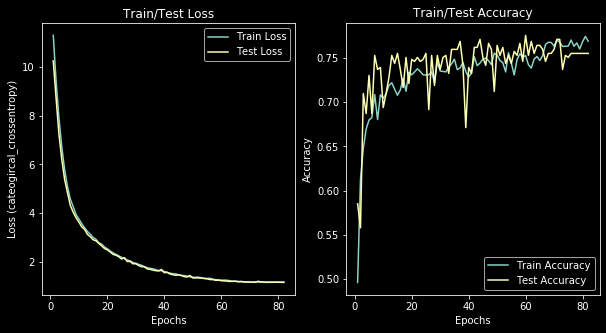

In [5]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/LossAccNormalBalancedAugment')  

### AUC and ROC Curves With Augment

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9183673469387754
HandGun: 0.6824324324324325
Rifle: 0.7123287671232876


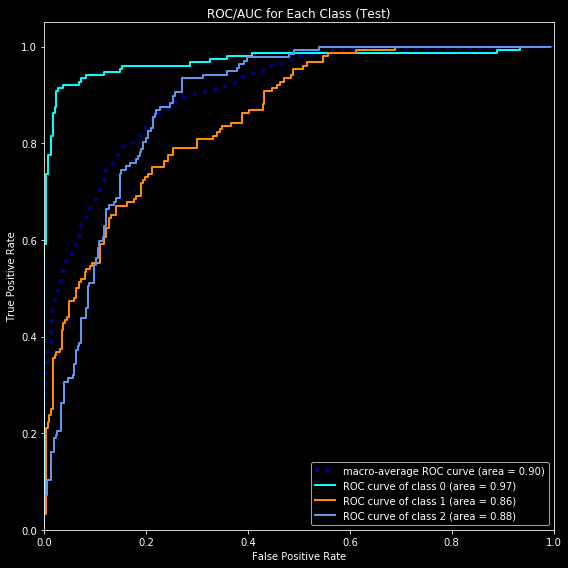

In [6]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/NormalBalancedAugment.h5') #load the best weights before overfitting
 


Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background')

### Confusion Matrix With Augment

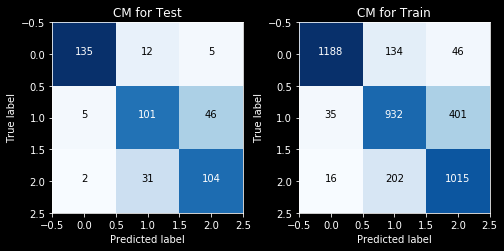

In [7]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/NormalBalancedAugment.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  )


In [ ]:
assert False

# No Augmention

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/NormalBalancedNoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim =dim)


normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


Train on 3969 samples, validate on 441 samples
Epoch 1/1000


INFO:plaidml:Analyzing Ops: 90 of 422 operations complete


3969/3969 [==============================] - 45s 11ms/step - loss: 11.3438 - acc: 0.5208 - val_loss: 10.2432 - val_acc: 0.6848

Epoch 00001: val_loss improved from inf to 10.24322, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 2/1000
3969/3969 [==============================] - 21s 5ms/step - loss: 9.4212 - acc: 0.6601 - val_loss: 8.6302 - val_acc: 0.6327

Epoch 00002: val_loss improved from 10.24322 to 8.63019, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 3/1000
3969/3969 [==============================] - 21s 5ms/step - loss: 7.9390 - acc: 0.7037 - val_loss: 7.4458 - val_acc: 0.6417

Epoch 00003: val_loss improved from 8.63019 to 7.44584, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 4/1000
3969/3969 [==============================] - 21s 5ms/step - loss: 6.8226 - acc: 0.7181 - val_loss: 6.3124 - val_acc: 0.7506

Epoch 00004: val_loss improved from 7.44584 to 6.31242, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 5/1000

3969/3969 [==============================] - 21s 5ms/step - loss: 1.8762 - acc: 0.9211 - val_loss: 2.2380 - val_acc: 0.7891

Epoch 00034: val_loss improved from 2.26690 to 2.23802, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 35/1000
3969/3969 [==============================] - 21s 5ms/step - loss: 1.8360 - acc: 0.9277 - val_loss: 2.1877 - val_acc: 0.8095

Epoch 00035: val_loss improved from 2.23802 to 2.18769, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 36/1000
3969/3969 [==============================] - 21s 5ms/step - loss: 1.7952 - acc: 0.9254 - val_loss: 2.3663 - val_acc: 0.7483

Epoch 00036: val_loss did not improve from 2.18769
Epoch 37/1000
3969/3969 [==============================] - 21s 5ms/step - loss: 1.9933 - acc: 0.8571 - val_loss: 2.1545 - val_acc: 0.7937

Epoch 00037: val_loss improved from 2.18769 to 2.15447, saving model to ModelWeights/NormalBalancedNoAugment.h5
Epoch 38/1000
3969/3969 [==============================] - 21s 5ms/step

### Loss and Accuracy without Augment

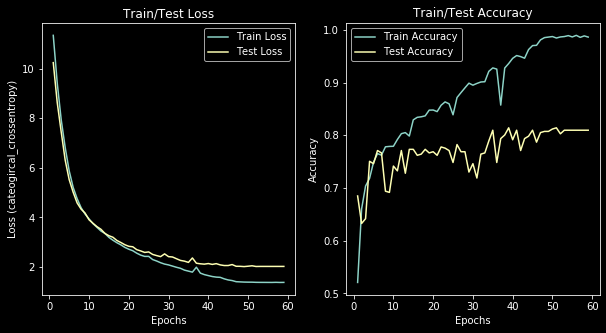

In [11]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/LossAccNormalBalancedNoAugment')  

### ROC and AUC without Augment

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8866666666666666
HandGun: 0.7539936102236421
Rifle: 0.7806691449814126


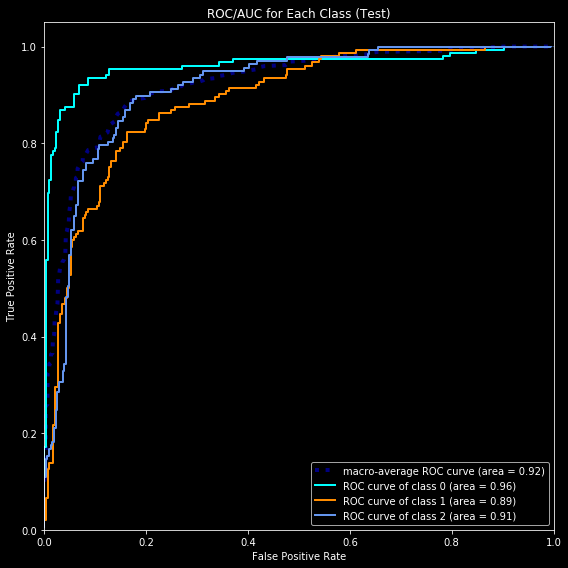

In [9]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/NormalBalancedNoAugment.h5') #load the best weights before overfitting
 


Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background')

### Confusion Matrix Without Augment

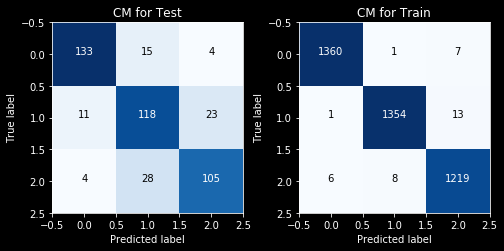

In [10]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/NormalBalancedNoAugment.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background')


## Results

- Comparing the confusion matrix of the augmented model with the non-augmented model, we can see that the non-augmented model performs much better at detection the presence of the weapon.  
- This difference can be due to the fact that the images that are being fed into the algorithm are already processes in a way that only makes it more confusing when applying augmentation as well
- The model weights `CNN-ModelCheckpointWeightsNoAugment.h5` correspond to the final model used throughout the visualizations found in `OpenCVTesting` notebook